<a href="https://colab.research.google.com/github/JotaPedroso/Machine-Learning/blob/main/XAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Machine Learning Explicável
!pip install lime
!pip install interpret
!pip install eli5
!pip install shap

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import IPython
import numpy as np
import eli5
from eli5 import show_prediction
import shap
import lime.lime_tabular
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

In [3]:
credito = pd.read_csv('Credit.csv')

In [4]:
credito.shape

(1000, 21)

In [5]:
credito.head()

checking_status  duration                    credit_history  \
0              <0         6  'critical/other existing credit'   
1        0<=X<200        48                   'existing paid'   
2   'no checking'        12  'critical/other existing credit'   
3              <0        42                   'existing paid'   
4              <0        24              'delayed previously'   

               purpose  credit_amount      savings_status employment  \
0             radio/tv           1169  'no known savings'        >=7   
1             radio/tv           5951                <100     1<=X<4   
2            education           2096                <100     4<=X<7   
3  furniture/equipment           7882                <100     4<=X<7   
4            'new car'           4870                <100     1<=X<4   

   installment_commitment       personal_status other_parties  ...  \
0                       4         'male single'          none  ...   
1                       2  'female div/dep/mar'          none  ...   
2                       2         'male single'          none  ...   
3                       2         'male single'     guarantor  ...   
4                       3         'male single'          none  ...   

    property_magnitude age  other_payment_plans     housing existing_credits  \
0        'real estate'  67                 none         own                2   
1        'real estate'  22                 none         own                1   
2        'real estate'  49                 none         own                1   
3     'life insurance'  45                 none  'for free'                1   
4  'no known property'  53                 none  'for free'                2   

                    job num_dependents  own_telephone foreign_worker class  
0               skilled              1            yes            yes  good  
1               skilled              1           none            yes   bad  
2  'unskilled resident'              2           none            yes  good  
3               skilled              2           none            yes  good  
4               skilled              2           none            yes   bad  

[5 rows x 21 columns]

In [6]:
previsores = credito.iloc[:, :-1].values # Divisão da classe do previsores
classe = credito.iloc[:, -1].values # Pega todas as linhas mas somente a ultima coluna

In [7]:
labelencoder = LabelEncoder()
for i in range(previsores.shape[1]): # percorre todas as colunas
  if previsores[:,i].dtype == 'object': # se a coluna for categorica (String)
    previsores[:,i] = labelencoder.fit_transform(previsores[:,i]) #Alteração dos dados catégoricos

In [8]:
classe = labelencoder.fit_transform(classe)

In [9]:
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(previsores, classe, test_size=0.3, random_state=0)

In [10]:
 modelo = RandomForestClassifier(n_estimators=1000)
 modelo.fit(X_treinamento, y_treinamento)

RandomForestClassifier(n_estimators=1000)

Lime

In [11]:
expl = lime.lime_tabular.LimeTabularExplainer(X_treinamento, feature_names=list(credito)[0:20], class_names="class")
# É a classe do LIME que trabalha com dados tabulares (tabelas, como planilhas).

prever = lambda x: modelo.predict_proba(x).astype(float)
# Função Lambda o LIME vai usar para chamar o seu modelo e obter as probabilidades das classes.

exp = expl.explain_instance(X_teste[0], prever, num_features=5)
# o LIME analisa pequenas variações dessa linha para entender quais colunas mais impactaram o resultado do modelo.
exp.show_in_notebook(show_all=True)

In [12]:
y_teste[0]

np.int64(1)

ELI5


In [13]:
eli5.show_weights(modelo, feature_names = list(credito)[0:20])
# Mostra os atributos e sua relevancia globalmente no modelo

In [14]:
previsores[1]

array([1, 29, 3, 7, 770, 3, 0, 1, 0, 2, 1, 2, 3, 1, 1, 0, 3, 0, 0, 1],
      dtype=object)

In [15]:
eli5.show_prediction(modelo, previsores[1], feature_names = list(credito)[0:20], show_feature_values = True)

SHAP

In [16]:
## biblioteca SHAP (SHapley Additive exPlanations) para explicar o impacto de cada variável (feature) ##

explainer = shap.TreeExplainer(modelo) # Criação do objeto explicador
shap_values = explainer.shap_values(X_teste) # o explainer calcula os valores SHAP para cada linha do conjunto de teste

abs_shap_values = np.abs(shap_values)

importancia_geral = np.mean(np.mean(abs_shap_values, axis = 2), axis = 0) # calcula a importância média global de cada variável
print(importancia_geral)


[0.09048728 0.04940672 0.02307121 0.01669715 0.03328126 0.02014037
 0.00859272 0.0170566  0.00986807 0.00491434 0.00845614 0.01671323
 0.01829366 0.01495526 0.01494236 0.00399837 0.00820588 0.00672609
 0.01044599 0.00223523]


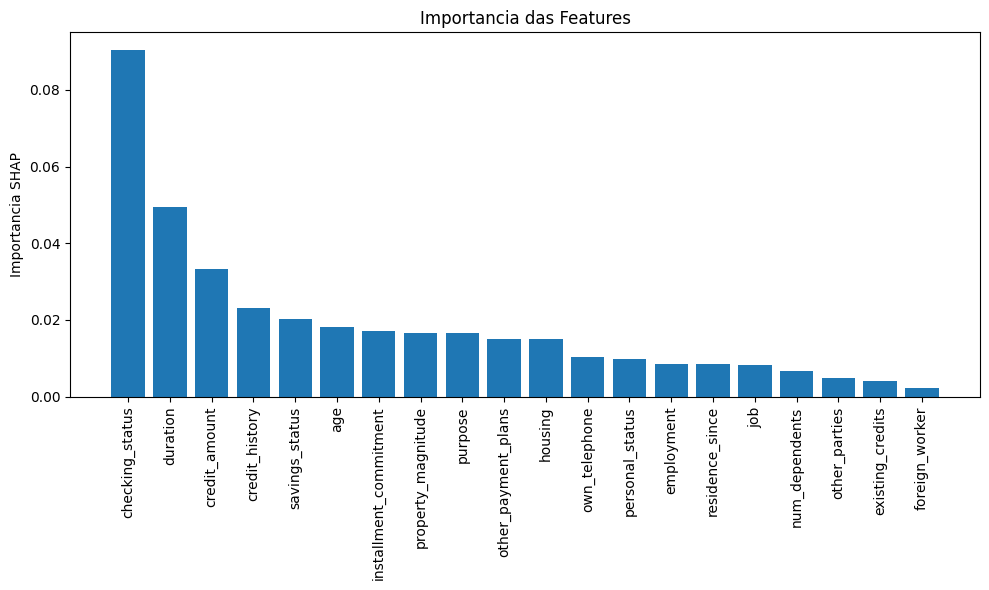

In [19]:
importancia_df = pd.DataFrame({ # Criação de um DataFrame
    'Feature' : credito.columns[:-1],
    'Importance' : importancia_geral
    }).sort_values(by = 'Importance', ascending = False) # ordena o DataFrame da variável mais importante para a menos importante.

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.bar(importancia_df['Feature'], importancia_df['Importance']) # Cria um grafico de barras. Eixo X - Features, Eixo Y - Importancia
plt.xticks(rotation = 90)
plt.ylabel("Importancia SHAP")
plt.title("Importancia das Features")
plt.tight_layout()
plt.show()

Interpret

In [20]:
set_visualize_provider(InlineProvider()) # Mostra a visualização apenas dentro do notebook
ebm = ExplainableBoostingClassifier(feature_names=list(credito)[0:20]) # cria um modelo de Machine Learning explicável, chamado EBM
ebm.fit(X_treinamento, y_treinamento)
global_explanation = ebm.explain_global() # Gera uma explicação global do modelo
show(global_explanation)